In [1]:
import mne
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [3]:

raw = mne.io.read_raw_bdf("/Users/alexnicorescu/Downloads/data.bdf")
raw.info["bads"].extend(['Accel X','Accel Y', 'Accel Z'])


Extracting EDF parameters from /Users/alexnicorescu/Downloads/data.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


incarcare date EEG


In [19]:

annotations_df = pd.read_csv("/Users/alexnicorescu/Downloads/annotations2.csv")


annotations_df = annotations_df[annotations_df['description'] != 'ignore']


annotations_df['onset'] = annotations_df['onset'] / 1e9


incarcare anotatii, ignorare pauze

Generated Events:
[[ 20000      0      1]
 [ 21250      0      1]
 [ 22500      0      1]
 [ 23750      0      1]
 [ 25000      0      1]
 [ 26250      0      1]
 [ 27500      0      1]
 [ 28750      0      1]
 [ 30000      0      1]
 [ 31250      0      1]
 [ 32500      0      1]
 [ 33750      0      1]
 [ 35000      0      1]
 [ 36250      0      1]
 [ 56250      0      2]
 [ 57500      0      2]
 [ 58750      0      2]
 [ 60000      0      2]
 [ 61250      0      2]
 [ 62500      0      2]
 [ 63750      0      2]
 [ 65000      0      2]
 [ 66250      0      2]
 [ 67500      0      2]
 [ 68750      0      2]
 [ 85000      0      1]
 [ 86250      0      1]
 [ 87500      0      1]
 [ 88750      0      1]
 [ 90000      0      1]
 [ 91250      0      1]
 [ 92500      0      1]
 [ 93750      0      1]
 [ 95000      0      1]
 [ 96250      0      1]
 [ 97500      0      1]
 [ 98750      0      1]
 [100000      0      1]
 [101250      0      1]
 [102500      0      1]
 [103750      0      1

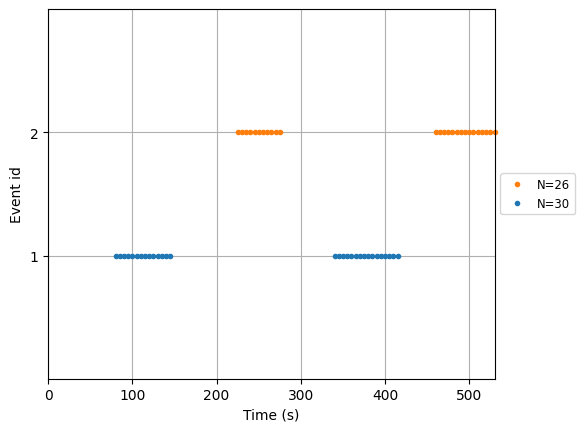

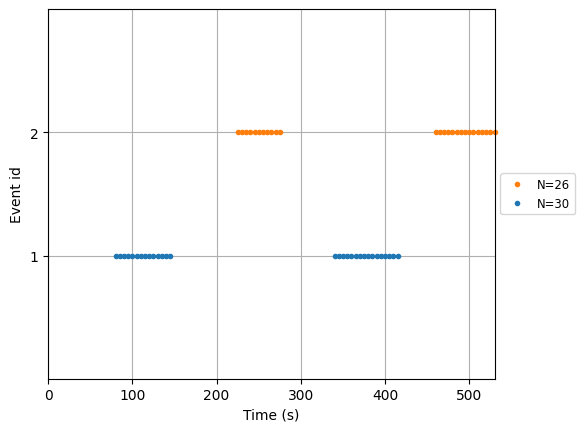

In [20]:

emotional_states = {'happy': 1, 'sad': 2}


events = []
for index, row in annotations_df.iterrows():
    onset_sample = int(row['onset'] * raw.info['sfreq'])
    events.append([onset_sample, 0, emotional_states[row['description']]])

events = np.array(events)
print("Generated Events:")
print(events)


mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)


labeluire, definirea evenimentelor si crearea epochilor

In [21]:

event_id = {'happy': 1, 'sad': 2}
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=5, baseline=None)



Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated


In [22]:
#psd
def eeg_power_band(epochs):
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)


X = eeg_power_band(epochs)
y = epochs.events[:, 2]


Loading data for 56 events and 1251 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


definirea benzilor de frecvnte, calcularea spectrului de putere pentru fiecare epoch, normnalizare valori psd pentru fiecare epoch. Extractia benzilor de frecventa. 
Exragere in X dupa mediere valori PSD pentru fiecare frecventa de banda concatenandu-le.

In [23]:

print("Class distribution in the dataset:")
print(pd.Series(y).value_counts())


split_idx = int(len(X) * 0.56)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


print("Class distribution in the training set:")
print(pd.Series(y_train).value_counts())
print("Class distribution in the test set:")
print(pd.Series(y_test).value_counts())


Class distribution in the dataset:
1    30
2    26
Name: count, dtype: int64
Class distribution in the training set:
1    20
2    11
Name: count, dtype: int64
Class distribution in the test set:
2    15
1    10
Name: count, dtype: int64


In [24]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Accuracy score: 0.68
Confusion Matrix:
[[8 2]
 [6 9]]


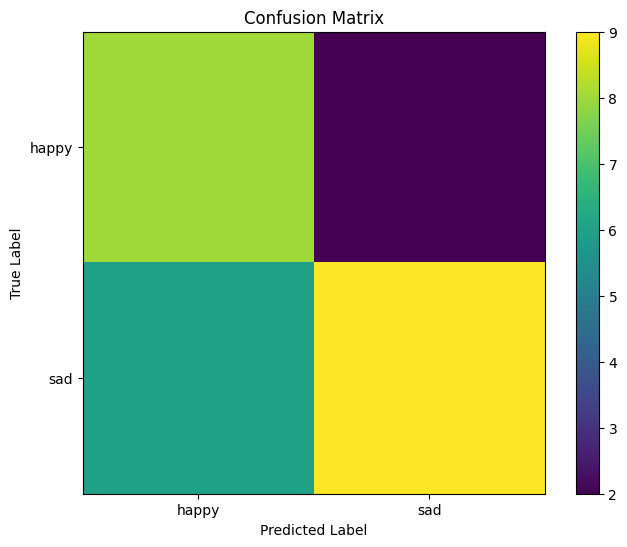

In [25]:

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy score: {acc}")
print(f"Confusion Matrix:\n{conf_matrix}")


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['happy', 'sad'])
plt.yticks([0, 1], ['happy', 'sad'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Extracting EDF parameters from /Users/alexnicorescu/Downloads/data.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Generated Events:
[[     0      0      0]
 [  1250      0      0]
 [  2500      0      0]
 [  3750      0      0]
 [  5000      0      0]
 [  6250      0      0]
 [  7500      0      0]
 [  8750      0      0]
 [ 10000      0      0]
 [ 11250      0      0]
 [ 12500      0      0]
 [ 13750      0      0]
 [ 15000      0      0]
 [ 16250      0      0]
 [ 17500      0      0]
 [ 18750      0      0]
 [ 20000      0      1]
 [ 21250      0      1]
 [ 22500      0      1]
 [ 23750      0      1]
 [ 25000      0      1]
 [ 26250      0      1]
 [ 27500      0      1]
 [ 28750      0      1]
 [ 30000      0      1]
 [ 31250      0      1]
 [ 32500      0      1]
 [ 33750      0      1]
 [ 35000      0      1]
 [ 36250      0      1]
 [ 37500      0      0]
 [ 56250      0      2]
 [ 57500      0      2]
 [ 58750      0      2]
 [ 60000 

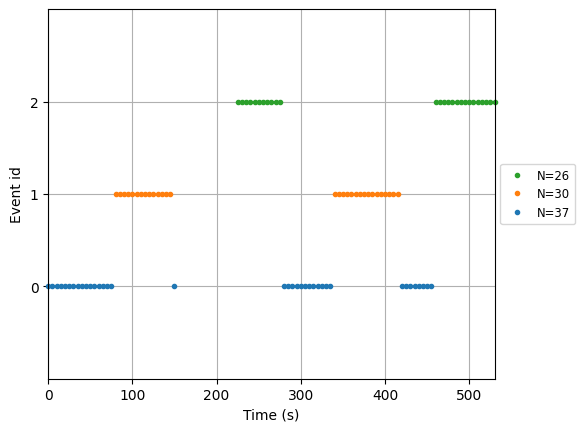

Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Loading data for 93 events and 1251 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Class distribution in the dataset:
0    37
1    30
2    26
Name: count, dtype: int64
Class distribution in the training set:
0    17
1    14
2     6
Name: count, dtype: int64
Class distribution in the test set:
2    20
0    20
1    16
Name: count, dtype: int64
Accuracy score: 0.2857142857142857
Confusion Matrix:
[[ 0 20  0]
 [ 0 16  0]
 [ 0 20  0]]


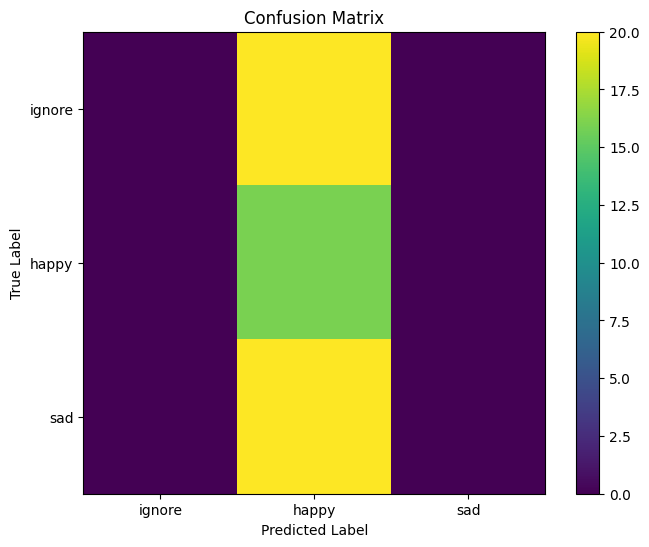

In [27]:
import mne
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load raw data
raw = mne.io.read_raw_bdf("/Users/alexnicorescu/Downloads/data.bdf")
raw.info["bads"].extend(['Accel X','Accel Y', 'Accel Z'])

# Load annotations
annotations_df = pd.read_csv("/Users/alexnicorescu/Downloads/annotations_ignore.csv")
annotations_df['onset'] = annotations_df['onset'] / 1e9

# Define emotional states including 'ignore'
emotional_states = {'happy': 1, 'sad': 2, 'ignore': 0}

# Generate events from annotations
events = []
for index, row in annotations_df.iterrows():
    onset_sample = int(row['onset'] * raw.info['sfreq'])
    events.append([onset_sample, 0, emotional_states[row['description']]])

events = np.array(events)
print("Generated Events:")
print(events)

# Plot events
mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)

# Define event_id including 'ignore'
event_id = {'happy': 1, 'sad': 2, 'ignore': 0}
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=5, baseline=None)

# Function to compute EEG power bands
def eeg_power_band(epochs):
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

# Compute features and labels
X = eeg_power_band(epochs)
y = epochs.events[:, 2]

print("Class distribution in the dataset:")
print(pd.Series(y).value_counts())

# Split dataset into training and test sets
split_idx = int(len(X) * 0.4)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Class distribution in the training set:")
print(pd.Series(y_train).value_counts())
print("Class distribution in the test set:")
print(pd.Series(y_test).value_counts())

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

# Evaluate classifier
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy score: {acc}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1, 2], ['ignore', 'happy', 'sad'])
plt.yticks([0, 1, 2], ['ignore', 'happy', 'sad'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


mai sus sunt luate in considerare si perioadele de pauza folosind Random forest

Extracting EDF parameters from /Users/alexnicorescu/Downloads/data.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Generated Events:
[[     0      0      0]
 [  1250      0      0]
 [  2500      0      0]
 [  3750      0      0]
 [  5000      0      0]
 [  6250      0      0]
 [  7500      0      0]
 [  8750      0      0]
 [ 10000      0      0]
 [ 11250      0      0]
 [ 12500      0      0]
 [ 13750      0      0]
 [ 15000      0      0]
 [ 16250      0      0]
 [ 17500      0      0]
 [ 18750      0      0]
 [ 20000      0      1]
 [ 21250      0      1]
 [ 22500      0      1]
 [ 23750      0      1]
 [ 25000      0      1]
 [ 26250      0      1]
 [ 27500      0      1]
 [ 28750      0      1]
 [ 30000      0      1]
 [ 31250      0      1]
 [ 32500      0      1]
 [ 33750      0      1]
 [ 35000      0      1]
 [ 36250      0      1]
 [ 37500      0      0]
 [ 56250      0      2]
 [ 57500      0      2]
 [ 58750      0      2]
 [ 60000 

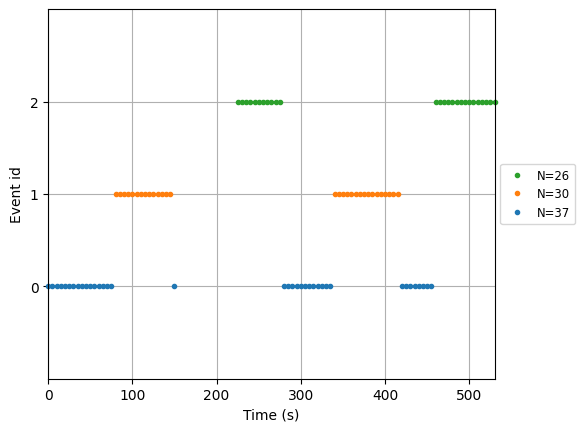

Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Loading data for 93 events and 1251 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Class distribution in the dataset:
0    37
1    30
2    26
Name: count, dtype: int64
Class distribution in the training set:
0    17
1    14
2     6
Name: count, dtype: int64
Class distribution in the test set:
2    20
0    20
1    16
Name: count, dtype: int64
Accuracy score: 0.44642857142857145
Confusion Matrix:
[[ 8  5  7]
 [ 4  6  6]
 [ 8  1 11]]


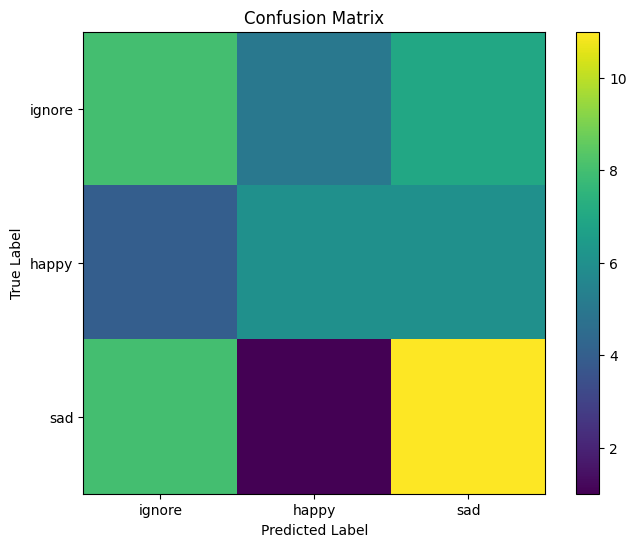

In [2]:
import mne
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load raw data
raw = mne.io.read_raw_bdf("/Users/alexnicorescu/Downloads/data.bdf")
raw.info["bads"].extend(['Accel X','Accel Y', 'Accel Z'])

# Load annotations
annotations_df = pd.read_csv("/Users/alexnicorescu/Downloads/annotations_ignore.csv")
annotations_df['onset'] = annotations_df['onset'] / 1e9

# Define emotional states including 'ignore'
emotional_states = {'happy': 1, 'sad': 2, 'ignore': 0}

# Generate events from annotations
events = []
for index, row in annotations_df.iterrows():
    onset_sample = int(row['onset'] * raw.info['sfreq'])
    events.append([onset_sample, 0, emotional_states[row['description']]])

events = np.array(events)
print("Generated Events:")
print(events)

# Plot events
mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)

# Define event_id including 'ignore'
event_id = {'happy': 1, 'sad': 2, 'ignore': 0}
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=5, baseline=None)

# Function to compute EEG power bands
def eeg_power_band(epochs):
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

# Compute features and labels
X = eeg_power_band(epochs)
y = epochs.events[:, 2]

print("Class distribution in the dataset:")
print(pd.Series(y).value_counts())

# Split dataset into training and test sets
split_idx = int(len(X) * 0.4)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Class distribution in the training set:")
print(pd.Series(y_train).value_counts())
print("Class distribution in the test set:")
print(pd.Series(y_test).value_counts())

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train classifier
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train_scaled, y_train)

# Evaluate classifier
y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy score: {acc}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1, 2], ['ignore', 'happy', 'sad'])
plt.yticks([0, 1, 2], ['ignore', 'happy', 'sad'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


mai sus se tine cont de perioadele de pauza, dar se foloseste SVM

Extracting EDF parameters from /Users/alexnicorescu/Downloads/data.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Generated Events:
[[     0      0      0]
 [  1250      0      0]
 [  2500      0      0]
 [  3750      0      0]
 [  5000      0      0]
 [  6250      0      0]
 [  7500      0      0]
 [  8750      0      0]
 [ 10000      0      0]
 [ 11250      0      0]
 [ 12500      0      0]
 [ 13750      0      0]
 [ 15000      0      0]
 [ 16250      0      0]
 [ 17500      0      0]
 [ 18750      0      0]
 [ 20000      0      1]
 [ 21250      0      1]
 [ 22500      0      1]
 [ 23750      0      1]
 [ 25000      0      1]
 [ 26250      0      1]
 [ 27500      0      1]
 [ 28750      0      1]
 [ 30000      0      1]
 [ 31250      0      1]
 [ 32500      0      1]
 [ 33750      0      1]
 [ 35000      0      1]
 [ 36250      0      1]
 [ 37500      0      0]
 [ 56250      0      2]
 [ 57500      0      2]
 [ 58750      0      2]
 [ 60000 

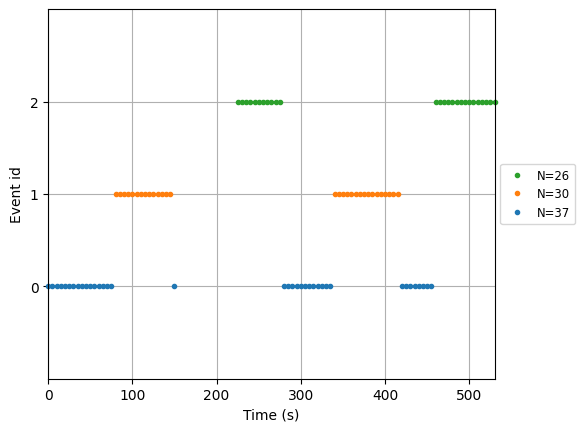

Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Loading data for 93 events and 1251 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Class distribution in the dataset:
0    37
1    30
2    26
Name: count, dtype: int64
Class distribution in the training set:
0    17
1    14
2     6
Name: count, dtype: int64
Class distribution in the test set:
2    20
0    20
1    16
Name: count, dtype: int64
Accuracy score: 0.44642857142857145
Confusion Matrix:
[[ 5  7  8]
 [ 2  5  9]
 [ 1  4 15]]


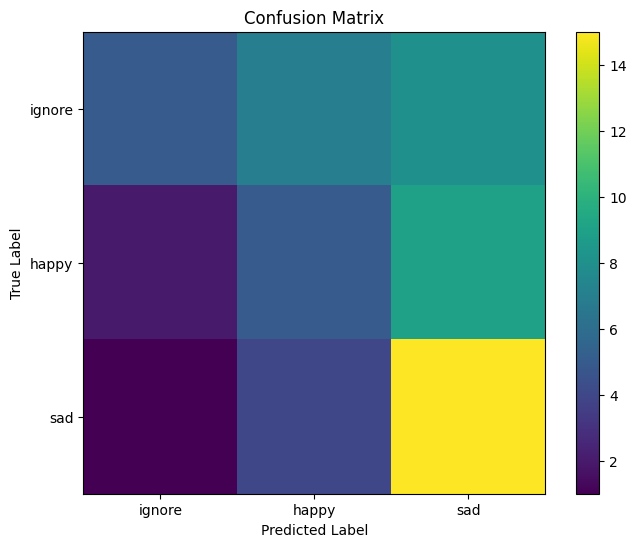

In [3]:
import mne
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


raw = mne.io.read_raw_bdf("/Users/alexnicorescu/Downloads/data.bdf")
raw.info["bads"].extend(['Accel X','Accel Y', 'Accel Z'])


annotations_df = pd.read_csv("/Users/alexnicorescu/Downloads/annotations_ignore.csv")
annotations_df['onset'] = annotations_df['onset'] / 1e9


emotional_states = {'happy': 1, 'sad': 2, 'ignore': 0}


events = []
for index, row in annotations_df.iterrows():
    onset_sample = int(row['onset'] * raw.info['sfreq'])
    events.append([onset_sample, 0, emotional_states[row['description']]])

events = np.array(events)
print("Generated Events:")
print(events)

mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)


event_id = {'happy': 1, 'sad': 2, 'ignore': 0}
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=5, baseline=None)


def eeg_power_band(epochs):
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

X = eeg_power_band(epochs)
y = epochs.events[:, 2]

print("Class distribution in the dataset:")
print(pd.Series(y).value_counts())

split_idx = int(len(X) * 0.4)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Class distribution in the training set:")
print(pd.Series(y_train).value_counts())
print("Class distribution in the test set:")
print(pd.Series(y_test).value_counts())


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)


y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy score: {acc}")
print(f"Confusion Matrix:\n{conf_matrix}")


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1, 2], ['ignore', 'happy', 'sad'])
plt.yticks([0, 1, 2], ['ignore', 'happy', 'sad'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


se tine cont de perioadele de pauza si se foloseste gradient

Extracting EDF parameters from /Users/alexnicorescu/Downloads/data.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Generated Events:
[[ 20000      0      1]
 [ 21250      0      1]
 [ 22500      0      1]
 [ 23750      0      1]
 [ 25000      0      1]
 [ 26250      0      1]
 [ 27500      0      1]
 [ 28750      0      1]
 [ 30000      0      1]
 [ 31250      0      1]
 [ 32500      0      1]
 [ 33750      0      1]
 [ 35000      0      1]
 [ 36250      0      1]
 [ 56250      0      2]
 [ 57500      0      2]
 [ 58750      0      2]
 [ 60000      0      2]
 [ 61250      0      2]
 [ 62500      0      2]
 [ 63750      0      2]
 [ 65000      0      2]
 [ 66250      0      2]
 [ 67500      0      2]
 [ 68750      0      2]
 [ 85000      0      1]
 [ 86250      0      1]
 [ 87500      0      1]
 [ 88750      0      1]
 [ 90000      0      1]
 [ 91250      0      1]
 [ 92500      0      1]
 [ 93750      0      1]
 [ 95000      0      1]
 [ 96250 

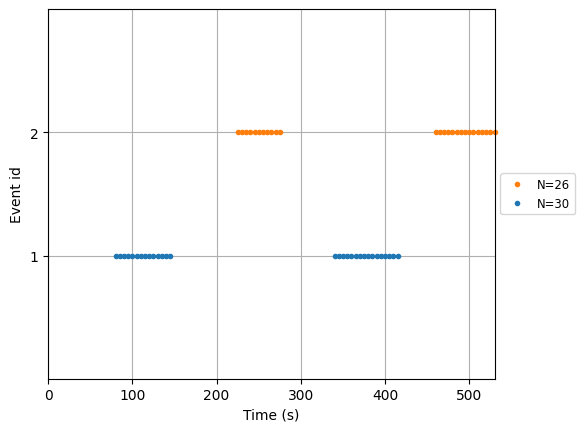

Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
Loading data for 56 events and 1251 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Class distribution in the dataset:
1    30
2    26
Name: count, dtype: int64
Class distribution in the training set:
1    20
2    11
Name: count, dtype: int64
Class distribution in the test set:
2    15
1    10
Name: count, dtype: int64

Support Vector Machine Model:
Accuracy score: 0.84
Confusion Matrix:
[[ 7  3]
 [ 1 14]]


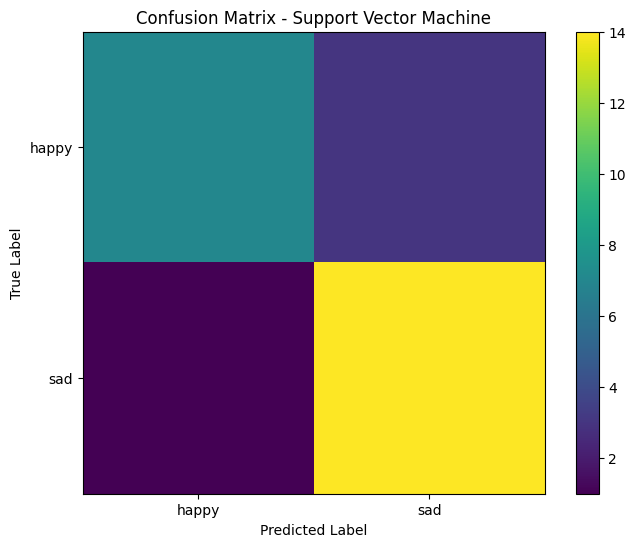


k-Nearest Neighbors Model:
Accuracy score: 0.6
Confusion Matrix:
[[7 3]
 [7 8]]


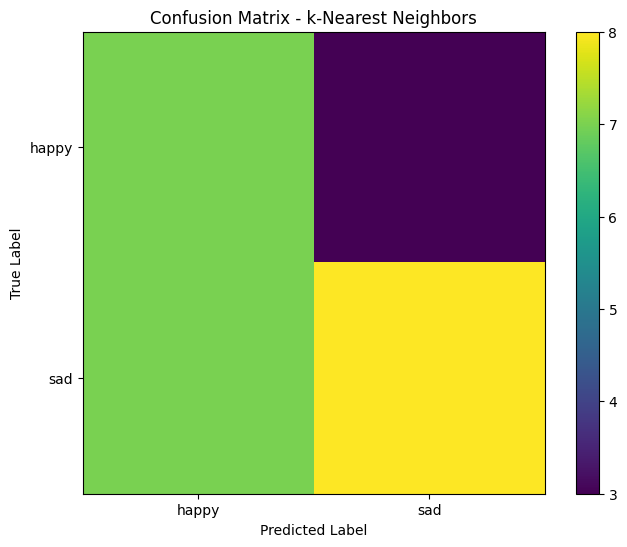


Gradient Boosting Model:
Accuracy score: 0.76
Confusion Matrix:
[[ 8  2]
 [ 4 11]]


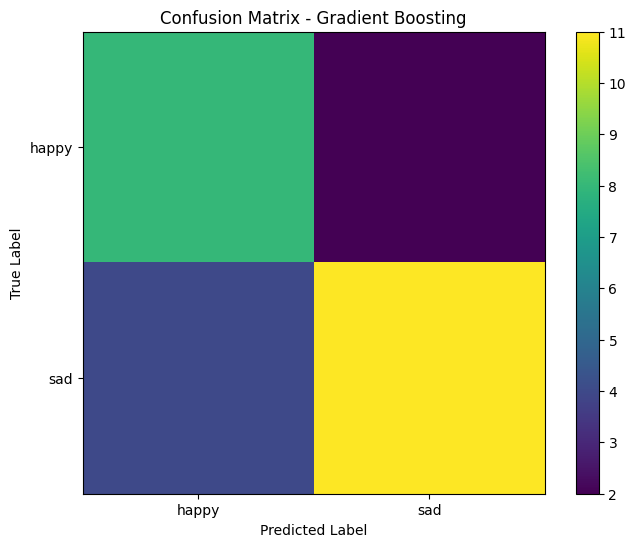

In [1]:
import mne
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


raw = mne.io.read_raw_bdf("/Users/alexnicorescu/Downloads/data.bdf")
raw.info["bads"].extend(['Accel X','Accel Y', 'Accel Z'])


annotations_df = pd.read_csv("/Users/alexnicorescu/Downloads/annotations2.csv")
annotations_df = annotations_df[annotations_df['description'] != 'ignore']
annotations_df['onset'] = annotations_df['onset'] / 1e9


emotional_states = {'happy': 1, 'sad': 2}


events = []
for index, row in annotations_df.iterrows():
    onset_sample = int(row['onset'] * raw.info['sfreq'])
    events.append([onset_sample, 0, emotional_states[row['description']]])

events = np.array(events)
print("Generated Events:")
print(events)

mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)


event_id = {'happy': 1, 'sad': 2}
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=5, baseline=None)


def eeg_power_band(epochs):
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)


X = eeg_power_band(epochs)
y = epochs.events[:, 2]

print("Class distribution in the dataset:")
print(pd.Series(y).value_counts())


split_idx = int(len(X) * 0.56)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Class distribution in the training set:")
print(pd.Series(y_train).value_counts())
print("Class distribution in the test set:")
print(pd.Series(y_test).value_counts())


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


models = {
    'Support Vector Machine': SVC(kernel='linear', random_state=42),
    'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Model:")
    print(f"Accuracy score: {acc}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
    plt.title(f'Confusion Matrix - {name}')
    plt.colorbar()
    plt.xticks([0, 1], ['happy', 'sad'])
    plt.yticks([0, 1], ['happy', 'sad'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


 k-NN este un algoritm de clasificare bazat pe similitudine. Când primești un nou punct de date, k-NN îl clasifică pe baza celor mai apropiați "k" vecini din setul de antrenament.

Gradient Boosting construiește un model puternic adăugând iterativ modele mai slabe (de obicei arbori de decizie), fiecare încercând să corecteze erorile făcute de modelele anterioare.

SVM găsește o hiperplană (sau limite de decizie în dimensiuni mai mari) care separă optim clasele de date, maximizând marja dintre ele.

Extracting EDF parameters from /Users/alexnicorescu/Downloads/data.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Generated Events:
[[ 20500      0      1]
 [ 21000      0      1]
 [ 21500      0      1]
 [ 22000      0      1]
 [ 22500      0      1]
 [ 23000      0      1]
 [ 23500      0      1]
 [ 24000      0      1]
 [ 24500      0      1]
 [ 25000      0      1]
 [ 25500      0      1]
 [ 26000      0      1]
 [ 26500      0      1]
 [ 27000      0      1]
 [ 27500      0      1]
 [ 28000      0      1]
 [ 28500      0      1]
 [ 29000      0      1]
 [ 29500      0      1]
 [ 30000      0      1]
 [ 30500      0      1]
 [ 31000      0      1]
 [ 31500      0      1]
 [ 32000      0      1]
 [ 32500      0      1]
 [ 33000      0      1]
 [ 33500      0      1]
 [ 34000      0      1]
 [ 34500      0      1]
 [ 35000      0      1]
 [ 35500      0      1]
 [ 36000      0      1]
 [ 36500      0      1]
 [ 37000      0      1]
 [ 56250 

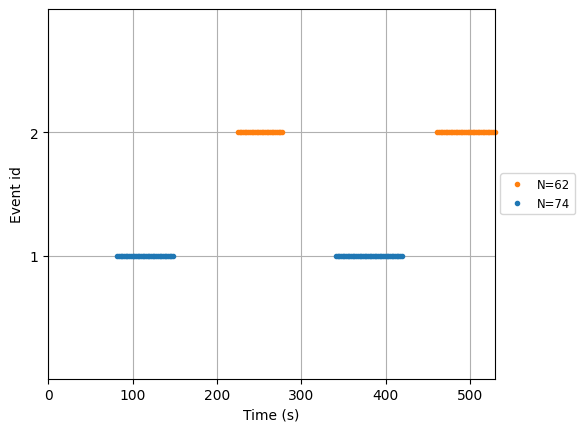

Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Loading data for 136 events and 501 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Class distribution in the dataset:
1    74
2    62
Name: count, dtype: int64
Class distribution in the training set:
1    49
2    27
Name: count, dtype: int64
Class distribution in the test set:
2    35
1    25
Name: count, dtype: int64

Support Vector Machine Model:
Accuracy score: 0.3
Confusion Matrix:
[[13 12]
 [30  5]]


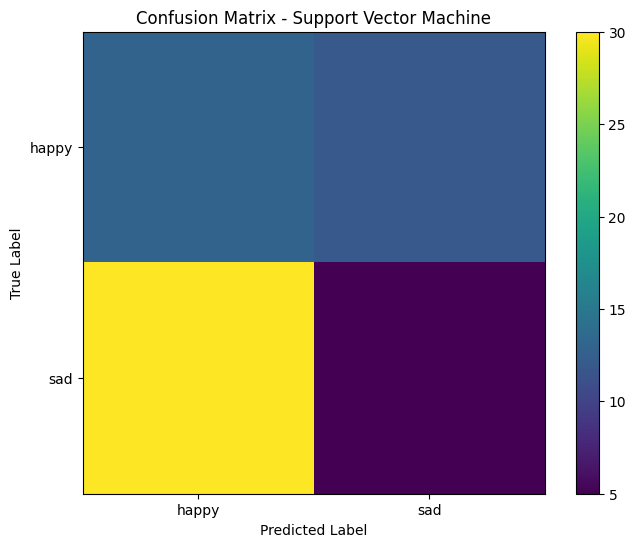


k-Nearest Neighbors Model:
Accuracy score: 0.36666666666666664
Confusion Matrix:
[[17  8]
 [30  5]]


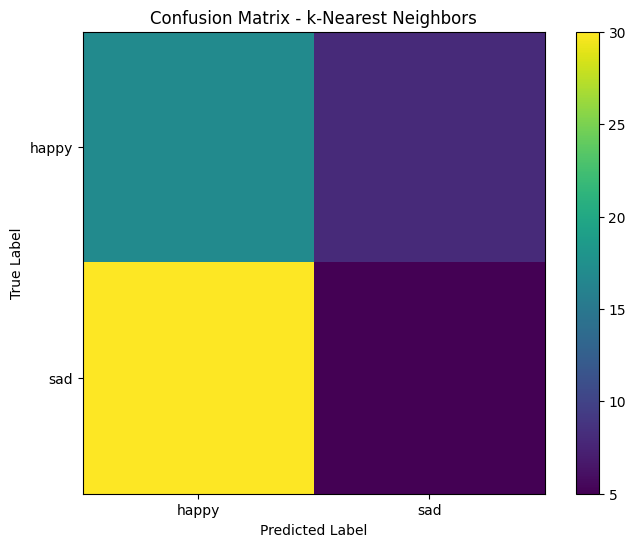


Gradient Boosting Model:
Accuracy score: 0.5666666666666667
Confusion Matrix:
[[18  7]
 [19 16]]


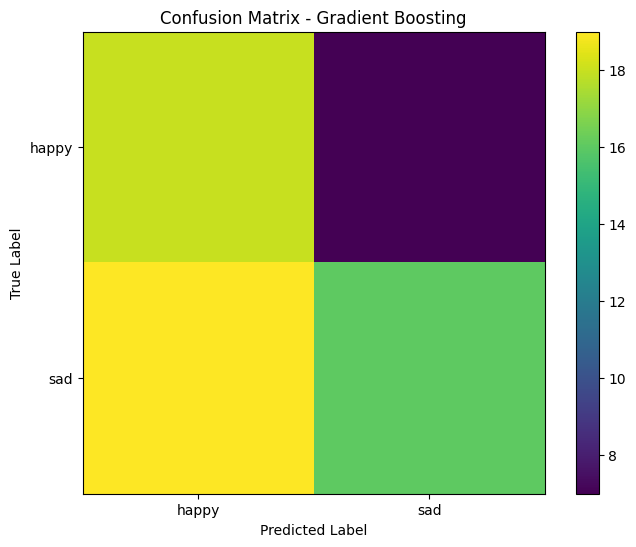

In [4]:
import mne
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


raw = mne.io.read_raw_bdf("/Users/alexnicorescu/Downloads/data.bdf")
raw.info["bads"].extend(['Accel X','Accel Y', 'Accel Z'])


annotations_df = pd.read_csv("/Users/alexnicorescu/Downloads/annotations3.csv")
annotations_df = annotations_df[annotations_df['description'] != 'ignore']
annotations_df['onset'] = annotations_df['onset'] / 1e9


emotional_states = {'happy': 1, 'sad': 2}


events = []
for index, row in annotations_df.iterrows():
    onset_sample = int(row['onset'] * raw.info['sfreq'])
    events.append([onset_sample, 0, emotional_states[row['description']]])

events = np.array(events)
print("Generated Events:")
print(events)

mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)


event_id = {'happy': 1, 'sad': 2}
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=2, baseline=None)


def eeg_power_band(epochs):
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)


X = eeg_power_band(epochs)
y = epochs.events[:, 2]

print("Class distribution in the dataset:")
print(pd.Series(y).value_counts())


split_idx = int(len(X) * 0.56)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Class distribution in the training set:")
print(pd.Series(y_train).value_counts())
print("Class distribution in the test set:")
print(pd.Series(y_test).value_counts())


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


models = {
    'Support Vector Machine': SVC(kernel='linear', random_state=42),
    'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Model:")
    print(f"Accuracy score: {acc}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
    plt.title(f'Confusion Matrix - {name}')
    plt.colorbar()
    plt.xticks([0, 1], ['happy', 'sad'])
    plt.yticks([0, 1], ['happy', 'sad'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


epoci de 2 secunde

Extracting EDF parameters from /Users/alexnicorescu/Downloads/data.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Generated Events:
[[ 20250      0      1]
 [ 20500      0      1]
 [ 20750      0      1]
 [ 21000      0      1]
 [ 21250      0      1]
 [ 21500      0      1]
 [ 21750      0      1]
 [ 56250      0      2]
 [ 58750      0      2]
 [ 61250      0      2]
 [ 63750      0      2]
 [ 66250      0      2]
 [ 85000      0      1]
 [ 87500      0      1]
 [ 90000      0      1]
 [ 92500      0      1]
 [ 95000      0      1]
 [ 97500      0      1]
 [100000      0      1]
 [102500      0      1]
 [115000      0      2]
 [117500      0      2]
 [120000      0      2]
 [122500      0      2]
 [125000      0      2]
 [127500      0      2]
 [130000      0      2]]


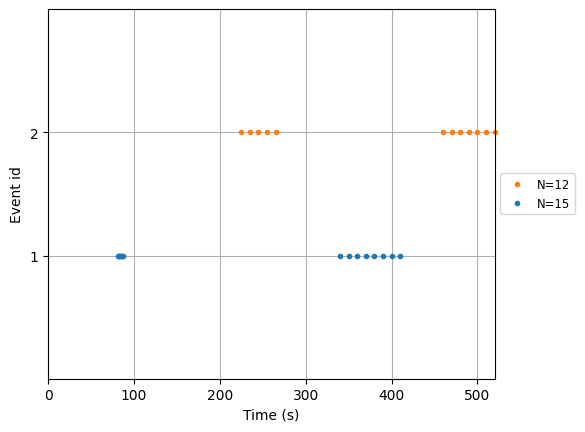

Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Loading data for 27 events and 2501 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Class distribution in the dataset:
1    15
2    12
Name: count, dtype: int64
Class distribution in the training set:
1    10
2     5
Name: count, dtype: int64
Class distribution in the test set:
2    7
1    5
Name: count, dtype: int64

Support Vector Machine Model:
Accuracy score: 0.4166666666666667
Confusion Matrix:
[[4 1]
 [6 1]]


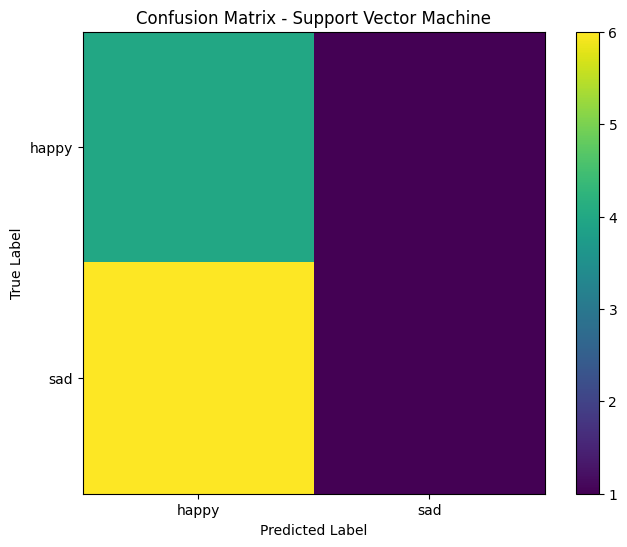


k-Nearest Neighbors Model:
Accuracy score: 0.3333333333333333
Confusion Matrix:
[[4 1]
 [7 0]]


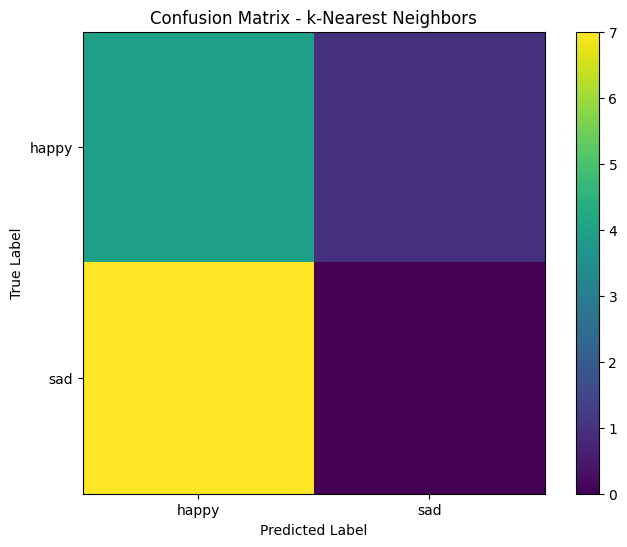


Gradient Boosting Model:
Accuracy score: 0.75
Confusion Matrix:
[[4 1]
 [2 5]]


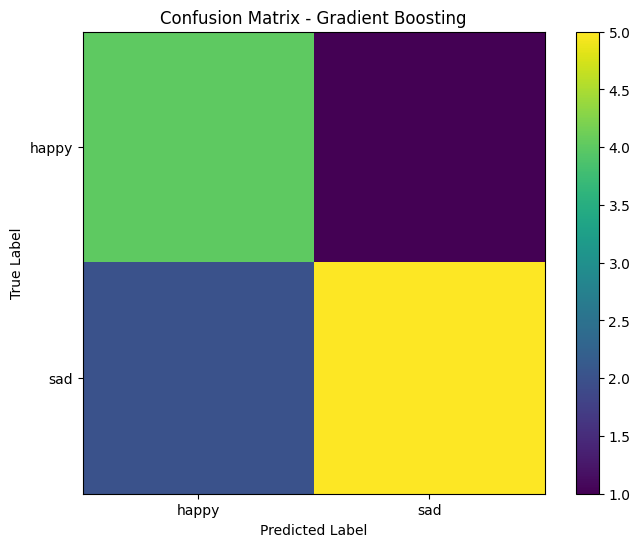

In [5]:
import mne
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


raw = mne.io.read_raw_bdf("/Users/alexnicorescu/Downloads/data.bdf")
raw.info["bads"].extend(['Accel X','Accel Y', 'Accel Z'])


annotations_df = pd.read_csv("/Users/alexnicorescu/Downloads/annotations4.csv")
annotations_df = annotations_df[annotations_df['description'] != 'ignore']
annotations_df['onset'] = annotations_df['onset'] / 1e9


emotional_states = {'happy': 1, 'sad': 2}


events = []
for index, row in annotations_df.iterrows():
    onset_sample = int(row['onset'] * raw.info['sfreq'])
    events.append([onset_sample, 0, emotional_states[row['description']]])

events = np.array(events)
print("Generated Events:")
print(events)

mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)


event_id = {'happy': 1, 'sad': 2}
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=10, baseline=None)


def eeg_power_band(epochs):
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)


X = eeg_power_band(epochs)
y = epochs.events[:, 2]

print("Class distribution in the dataset:")
print(pd.Series(y).value_counts())


split_idx = int(len(X) * 0.56)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Class distribution in the training set:")
print(pd.Series(y_train).value_counts())
print("Class distribution in the test set:")
print(pd.Series(y_test).value_counts())


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


models = {
    'Support Vector Machine': SVC(kernel='linear', random_state=42),
    'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Model:")
    print(f"Accuracy score: {acc}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
    plt.title(f'Confusion Matrix - {name}')
    plt.colorbar()
    plt.xticks([0, 1], ['happy', 'sad'])
    plt.yticks([0, 1], ['happy', 'sad'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


epoci de 10 secunde